In [1]:
# importing modules and libraries

import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Flatten, ELU, Dense, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import Nadam

2024-06-05 05:21:47.354884: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 05:21:47.354983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 05:21:47.484272: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 1658 files belonging to 9 classes.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


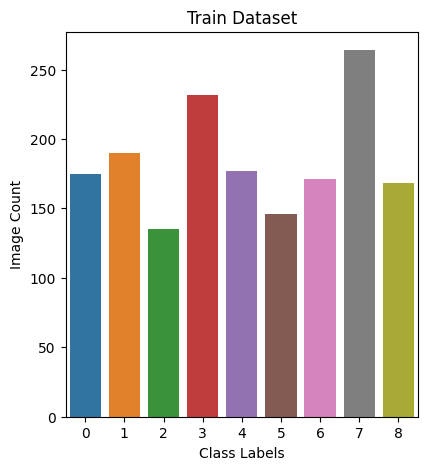

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Loading train and val datasets
train_dataset = keras.utils.image_dataset_from_directory(
    "/kaggle/input/date-fruit-image-dataset-in-controlled-environment",
    image_size=(224, 224),
    batch_size=32
)

# Collecting class labels
train_labels = []
for _, labels in train_dataset:
    train_labels.extend(labels.numpy())

# Counting occurrences of each label
train_label_counts = Counter(train_labels)

# Plotting the counts
plt.figure(figsize=(10, 5))

# Train dataset
plt.subplot(1, 2, 1)
sns.barplot(x=list(train_label_counts.keys()), y=list(train_label_counts.values()))
plt.title('Train Dataset')
plt.xlabel('Class Labels')
plt.ylabel('Image Count')
plt.show()

In [3]:
# Loading train and val datasets
train_dataset = keras.utils.image_dataset_from_directory(
    "/kaggle/input/date-fruit-image-dataset-in-controlled-environment",
    image_size=(224, 224),
    batch_size=32
)

# Normalizing datasets
normalization_layer = keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))

# Converting the datasets to lists of images and labels
train_images = []
train_labels = []
for images, labels in train_dataset:
    for image, label in zip(images, labels):
        train_images.append(image.numpy())
        train_labels.append(label.numpy())

# Converting to arrays
images = np.array(train_images)
labels = np.array(train_labels)

# Converting labels to probability distributions
labels = keras.utils.to_categorical(labels, 9)

Found 1658 files belonging to 9 classes.


In [4]:
# Split the data
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.4,random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)

x_train: (994, 224, 224, 3)
y_train: (994, 9)
x_test: (332, 224, 224, 3)
y_test: (332, 9)
x_val: (332, 224, 224, 3)
y_val: (332, 9)


In [5]:
import gc # calling garbage collector to reduce memory utilization

del train_dataset

gc.collect()

264

In [6]:
from keras import mixed_precision # changing precision policies
mixed_precision.set_global_policy('mixed_float16')

In [7]:
tf.config.optimizer.set_jit(True) # setting optimizer to reduce model computation by optimizing graph-computations

### VGG16

In [8]:
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau

# Loading model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('block4_pool').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(9, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

model.summary() # printing summary of model

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,169,801 (31.17 MB)

 Trainable params: 534,537 (2.04 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=10,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
  9/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1810 - loss: 2.4837 

I0000 00:00:1717565010.608992     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2261 - loss: 2.4104
Epoch 1: val_accuracy improved from -inf to 0.53313, saving model to model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.2271 - loss: 2.4066 - val_accuracy: 0.5331 - val_loss: 1.4144 - learning_rate: 0.0010
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6222 - loss: 1.2025
Epoch 2: val_accuracy improved from 0.53313 to 0.73795, saving model to model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6225 - loss: 1.2012 - val_accuracy: 0.7380 - val_loss: 0.8962 - learning_rate: 0.0010
Epoch 3/20
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8211 - loss: 0.7116
Epoch 3: val_accuracy improved from 0.73795 to 0.82229, saving model to model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8214 - loss: 0.7105 - val_accuracy: 0.8223 - val_loss: 0.6443 - learning_rate: 0.0010
Epoch 4/20
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8706 -

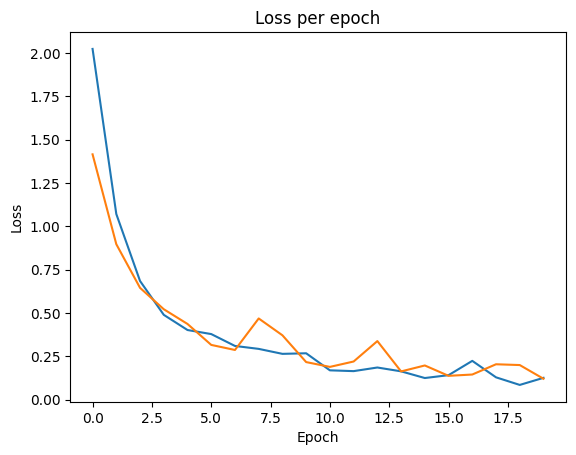

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

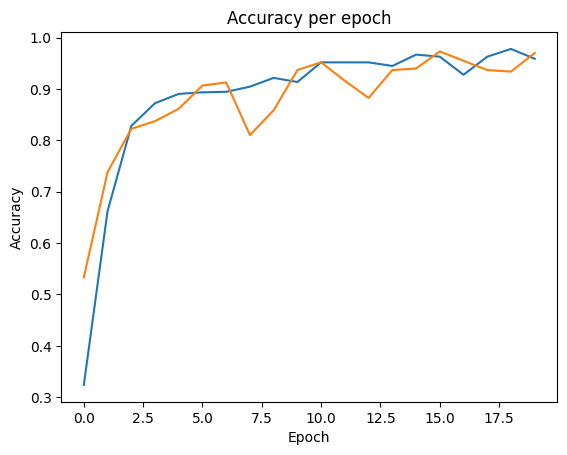

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### ResNet50

In [12]:
from keras.applications import ResNet50
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=resnet50_model.input, outputs=resnet50_model.get_layer('conv4_block3_out').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(9, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

# Setting callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 210,754,953 (803.97 MB)

 Trainable params: 205,531,145 (784.04 MB)

 Non-trainable params: 5,223,808 (19.93 MB)

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=10,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
  3/100 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.0278 - loss: 3.0713     

W0000 00:00:1717565082.142747     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.1052 - loss: 12.3830

W0000 00:00:1717565094.855542     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717565098.665855     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.12048, saving model to model.keras


W0000 00:00:1717565103.576236     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 375ms/step - accuracy: 0.1054 - loss: 12.3963 - val_accuracy: 0.1205 - val_loss: 14.1762 - learning_rate: 0.0010
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.1141 - loss: 14.2785
Epoch 2: val_accuracy did not improve from 0.12048
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.1142 - loss: 14.2776 - val_accuracy: 0.1205 - val_loss: 14.1762 - learning_rate: 0.0010
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.1322 - loss: 13.9876
Epoch 3: val_accuracy did not improve from 0.12048
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.1321 - loss: 13.9896 - val_accuracy: 0.1205 - val_loss: 14.1762 - learning_rate: 0.0010
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.1244 - loss: 14.1123
Epoch 4: val_accuracy did not improve from 0.12048
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.1244 - loss: 14.1131 - val_accuracy: 0.1205 - val_loss: 14.1762 - learning_rate: 0.0010
Epoch

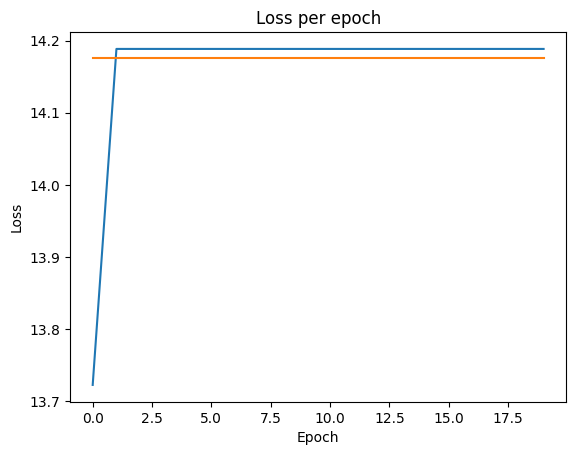

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

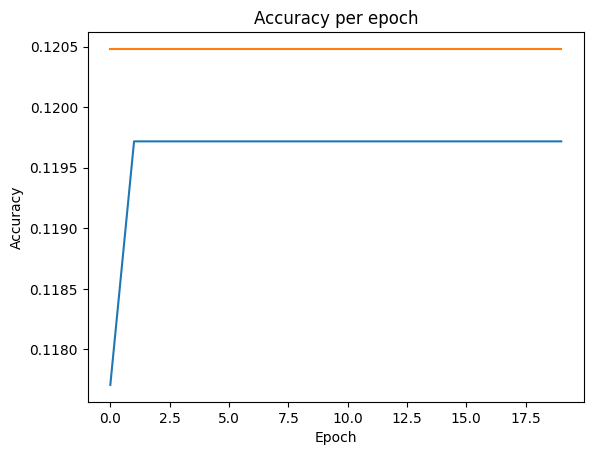

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### DenseNet121

In [16]:
from keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
densenet121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=densenet121_model.input, outputs=densenet121_model.get_layer('conv5_block6_concat').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False
    
# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
output = Dense(9, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 6,271,433 (23.92 MB)

 Trainable params: 731,145 (2.79 MB)

 Non-trainable params: 5,540,288 (21.13 MB)

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=10,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.1831 - loss: 2.1110
Epoch 1: val_accuracy improved from -inf to 0.59036, saving model to model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 74s 441ms/step - accuracy: 0.1844 - loss: 2.1097 - val_accuracy: 0.5904 - val_loss: 1.6821 - learning_rate: 0.0010
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5995 - loss: 1.5065
Epoch 2: val_accuracy improved from 0.59036 to 0.75000, saving model to model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6002 - loss: 1.5051 - val_accuracy: 0.7500 - val_loss: 1.0803 - learning_rate: 0.0010
Epoch 3/20
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7589 - loss: 0.9672
Epoch 3: val_accuracy improved from 0.75000 to 0.78012, saving model to model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7609 - loss: 0.9635 - val_accuracy: 0.7801 - val_loss: 0.7238 - learning_rate: 0.0010
Epoch 4/20
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accura

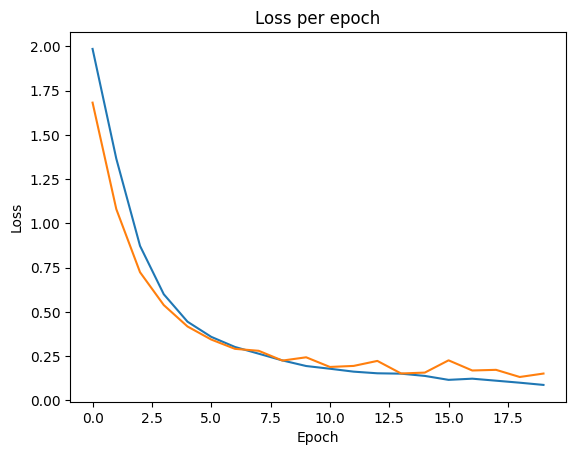

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

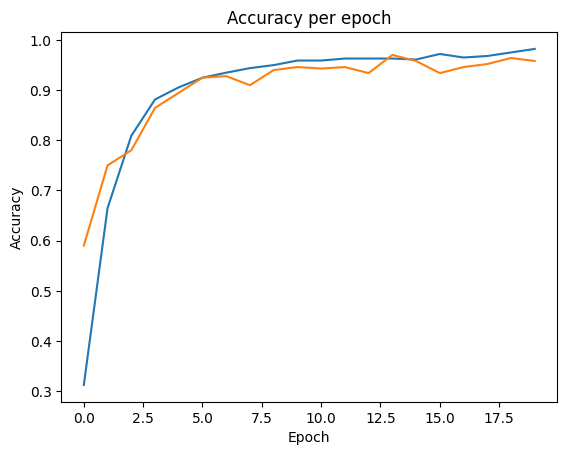

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### Xception

In [20]:
from keras.applications import Xception
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=xception_model.input, outputs=xception_model.get_layer('block14_sepconv2_act').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(9, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_3[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 22,968,881 (87.62 MB)

 Trainable params: 2,107,401 (8.04 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=10,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4956 - loss: 1.7224
Epoch 1: val_accuracy improved from -inf to 0.79217, saving model to model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 185ms/step - accuracy: 0.4974 - loss: 1.7155 - val_accuracy: 0.7922 - val_loss: 0.5183 - learning_rate: 0.0010
Epoch 2/20
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8775 - loss: 0.3965
Epoch 2: val_accuracy improved from 0.79217 to 0.86446, saving model to model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8775 - loss: 0.3960 - val_accuracy: 0.8645 - val_loss: 0.4098 - learning_rate: 0.0010
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9241 - loss: 0.2438
Epoch 3: val_accuracy improved from 0.86446 to 0.91265, saving model to model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9240 - loss: 0.2440 - val_accuracy: 0.9127 - val_loss: 0.2462 - learning_rate: 0.0010
Epoch 4/20
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accurac

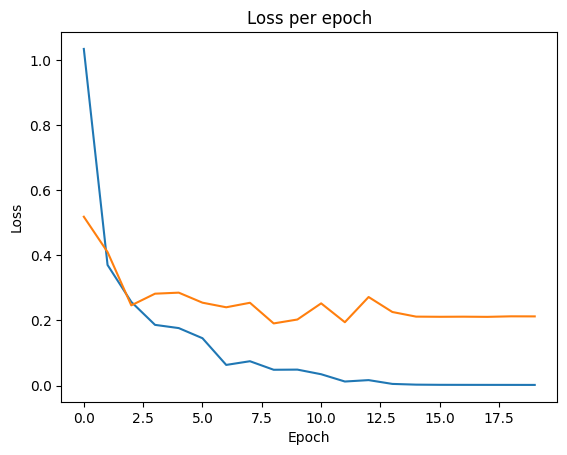

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

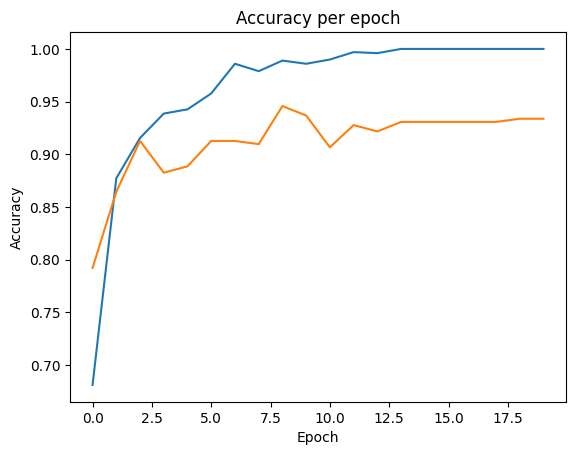

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### Inception

In [24]:
from keras.applications import InceptionV3
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=inception_model.input, outputs=inception_model.get_layer('mixed10').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(9, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 111, 111,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,910,185 (91.21 MB)

 Trainable params: 2,107,401 (8.04 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=10,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.2923 - loss: 6.6592
Epoch 1: val_accuracy improved from -inf to 0.78012, saving model to model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 56s 344ms/step - accuracy: 0.2945 - loss: 6.6303 - val_accuracy: 0.7801 - val_loss: 0.6239 - learning_rate: 0.0010
Epoch 2/20
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8397 - loss: 0.4821
Epoch 2: val_accuracy improved from 0.78012 to 0.82229, saving model to model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step - accuracy: 0.8395 - loss: 0.4822 - val_accuracy: 0.8223 - val_loss: 0.5371 - learning_rate: 0.0010
Epoch 3/20
 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8717 - loss: 0.2993
Epoch 3: val_accuracy did not improve from 0.82229
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8720 - loss: 0.2994 - val_accuracy: 0.7711 - val_loss: 0.6723 - learning_rate: 0.0010
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9293 - loss: 0.1929
Epoch 

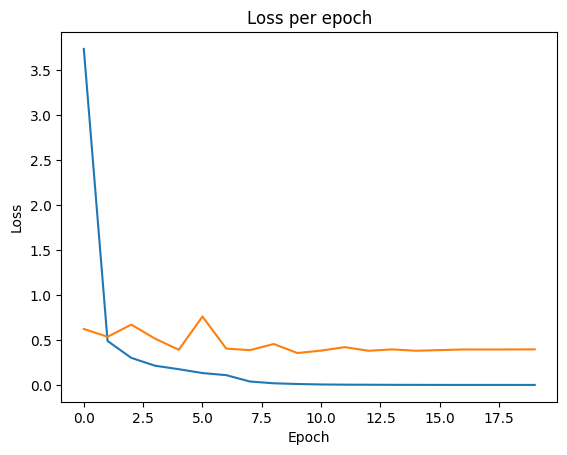

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

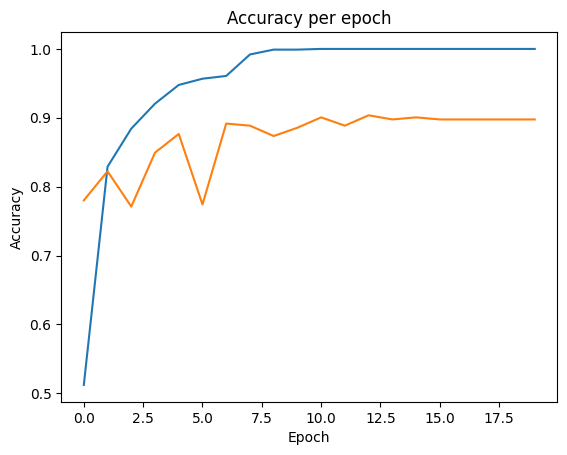

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### EfficientNet

In [28]:
from keras.applications import EfficientNetB7
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
efficientnet_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=efficientnet_model.input, outputs=efficientnet_model.get_layer('top_activation').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(9, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_2[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      2,048 │ block1a_se_excit

 Total params: 66,729,376 (254.55 MB)

 Trainable params: 2,631,689 (10.04 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=10,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1200 - loss: 2.8153  
Epoch 1: val_accuracy improved from -inf to 0.10843, saving model to model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.1201 - loss: 2.8117 - val_accuracy: 0.1084 - val_loss: 2.2337 - learning_rate: 0.0010
Epoch 2/20
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1275 - loss: 2.2154
Epoch 2: val_accuracy improved from 0.10843 to 0.18373, saving model to model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.1277 - loss: 2.2152 - val_accuracy: 0.1837 - val_loss: 2.1867 - learning_rate: 0.0010
Epoch 3/20
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1485 - loss: 2.1842
Epoch 3: val_accuracy did not improve from 0.18373
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.1484 - loss: 2.1842 - val_accuracy: 0.1837 - val_loss: 2.1792 - learning_rate: 0.0010
Epoch 4/20
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1462 - loss: 2.1731
Epoch 4: v

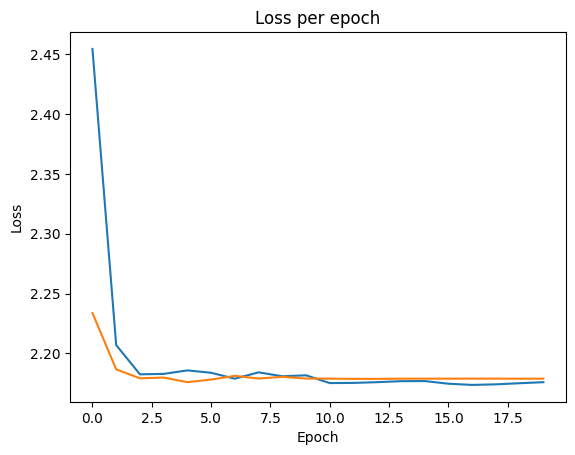

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

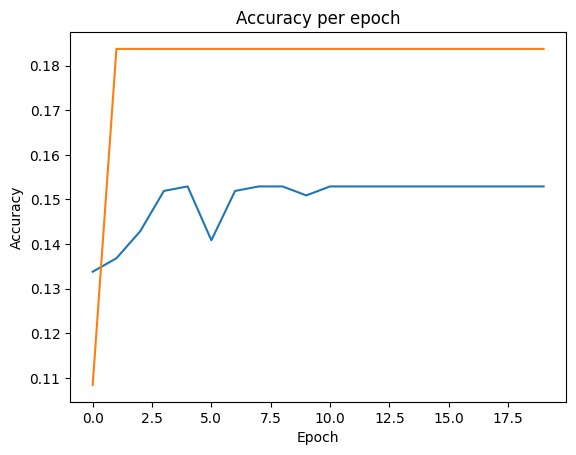

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### CNN

In [44]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, InputLayer
from keras.regularizers import l1_l2

model = Sequential()

model.add(InputLayer(shape=(224, 224, 3))) # input layer

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same',kernel_regularizer=l1_l2(0.001,0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same',kernel_regularizer=l1_l2(0.001,0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same',kernel_regularizer=l1_l2(0.001,0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same',kernel_regularizer=l1_l2(0.0001,0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(GlobalAveragePooling2D()) # pooling down

model.add(Dense(1024, activation='relu')) # dense layer

model.add(Dense(9, activation='softmax')) # output layer

model.summary() # model summary

# model checkpoint callback
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_110 (Conv2D)             │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_110         │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_111         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_113         │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 9)              │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,385 (739.79 KB)

 Trainable params: 188,873 (737.79 KB)

 Non-trainable params: 512 (2.00 KB)

In [45]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=10,callbacks=[model_checkpoint])

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3580 - loss: 4.1821
Epoch 1: val_accuracy improved from -inf to 0.12048, saving model to model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.3592 - loss: 4.1749 - val_accuracy: 0.1205 - val_loss: 4.5114
Epoch 2/30
 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6736 - loss: 2.2850
Epoch 2: val_accuracy did not improve from 0.12048
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6739 - loss: 2.2805 - val_accuracy: 0.1084 - val_loss: 5.8304
Epoch 3/30
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7662 - loss: 1.6879
Epoch 3: val_accuracy did not improve from 0.12048
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7659 - loss: 1.6855 - val_accuracy: 0.1205 - val_loss: 8.8900
Epoch 4/30
 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7660 - loss: 1.4625
Epoch 4: val_accuracy did not improve from 0.12048
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7658 - 

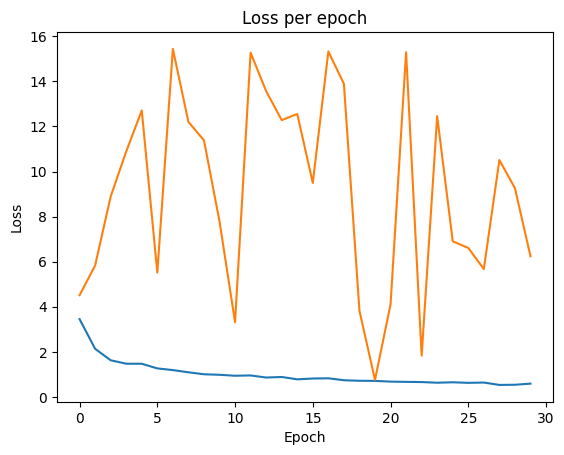

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

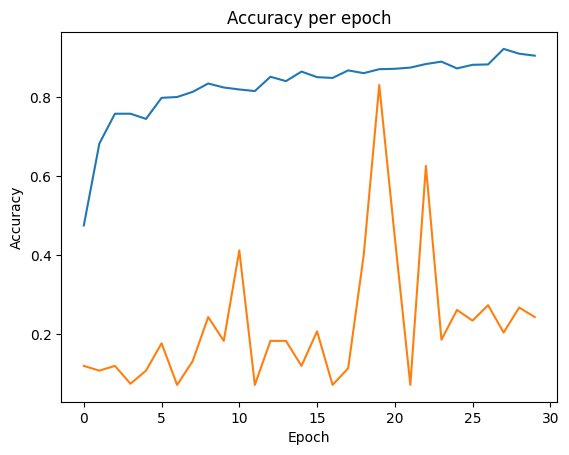

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()